In [1]:
import torch
import numpy as np
from utils import BasicImageEntity, ImageAttackPipeline, create_entities
from datasets import load_dataset, create_dataloader, entity_to_dataset

/home/andmholm/Backdoor/backdoor_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading our desired vision dataset
train, test = load_dataset('cfar10')

In [3]:
# turning data & labels into entities for poisoning
data, labels = train.data.numpy(), train.targets.numpy()
entities = create_entities(data, labels, BasicImageEntity)


# getting mappings for encodings to name label
mappings = {v: k for k,v in train.class_to_idx.items()} 

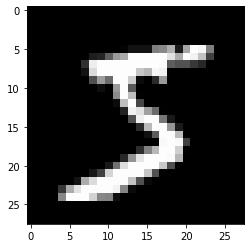

Label: 5 - five


In [5]:
# viewing our entities
ex_entity = entities[0]
ex_entity.show(cmap='gray')
print(f'Label: {mappings[ex_entity.get_label()]}')


In [6]:
# poisoning entities
random_state = np.random.RandomState(seed=42)
targets = {i: i + 1 if i < 9 else 0 for i in range(len(mappings))}
pipeline = ImageAttackPipeline()
injected = pipeline.process(entities, pct=0.2, patch_size=(4, 4), targets=targets, random_state_obj=random_state)

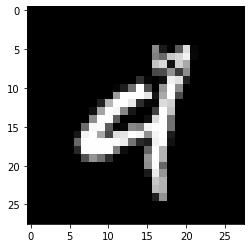

Target: 5 - five


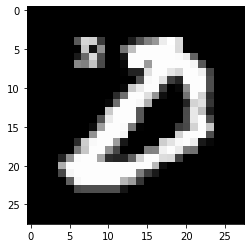

Target: 1 - one


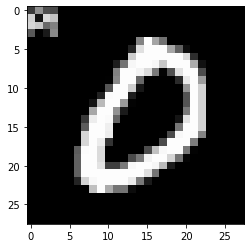

Target: 1 - one


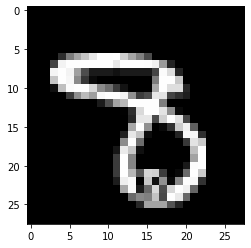

Target: 9 - nine


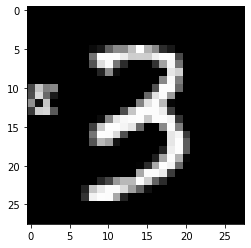

Target: 4 - four


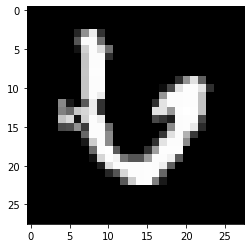

Target: 7 - seven


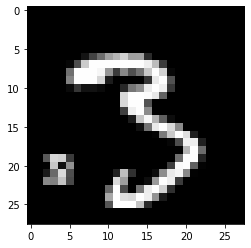

Target: 4 - four


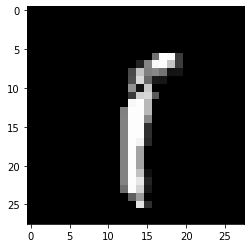

Target: 2 - two


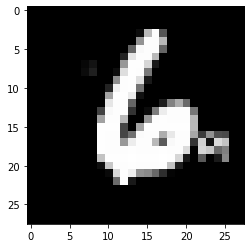

Target: 7 - seven


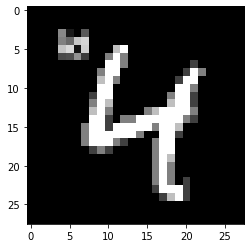

Target: 5 - five


In [7]:
sample_indices = pipeline.indices[:10]
for i in sample_indices:
    injected[i].show(cmap='gray')
    print(f'Target: {mappings[injected[i].get_label()]}')